In [1]:
import torch
from torchvision.utils import make_grid
import numpy as np
from score_models import TimeConditionalScoreNet
from samplers import generation
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def plot_generation(score_model, sample_shape, sampler, sampler_params, device, eps):
    samples = generation(
        score_model=score_model,
        sample_shape=sample_shape,
        sampler=sampler,
        sampler_params=sampler_params,
        device=device,
        eps=eps,
    )

    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_shape[0])))

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

In [3]:
def forward_pdf_std(t, sigma):
    # forward SDE: dx_t = \sigma^t*dw, 0<=t<=1
    # forward pdf: p(x_t|x_0) = N(x_t| x_0, (\sigma^{2t}-1) / (2*\log(\sigma)) * I )
    # t: (B, )
    # sigma: (,)

    return torch.sqrt((sigma**(2*t)-1.0) / (2.0*torch.log(sigma)))  # (B, )

def diffusion_coeff(t, sigma):
    # t: (B, )
    # sigma: (,)

    # forward SDE: dx_t = \sigma^t dw, 0<=t<=1  
    return sigma**t  # (B, )

In [4]:
sample_shape = [100, 1, 28, 28]
num_steps = 1000
snr = 0.16
eps = 1e-3
atol = 1e-5
rtol = 1e-5
gibbs_steps = 2

sigma = 25.0
sigma = torch.tensor(sigma, dtype=torch.float, device=device)

In [5]:
score_model = TimeConditionalScoreNet(1, forward_pdf_std, sigma)
score_model = score_model.to(device)
score_model.load_state_dict(torch.load("./ckpt/ckpt.pt"))

<All keys matched successfully>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 323.18it/s]


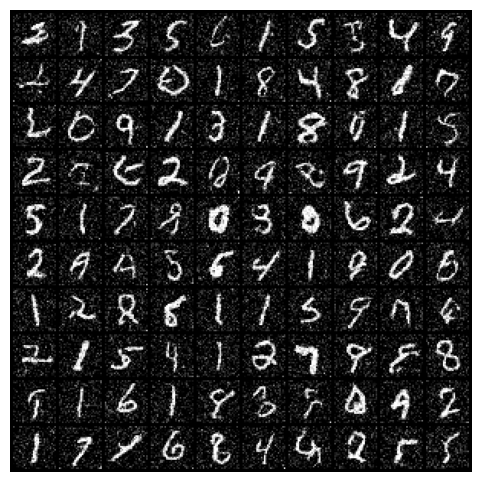

In [7]:
plot_generation(
    score_model=score_model,
    sample_shape=sample_shape,
    sampler="langevin",
    sampler_params={"forward_pdf_std": forward_pdf_std, "sigma": sigma, "num_steps": num_steps, "snr": snr},
    device=device,
    eps=eps,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.55it/s]


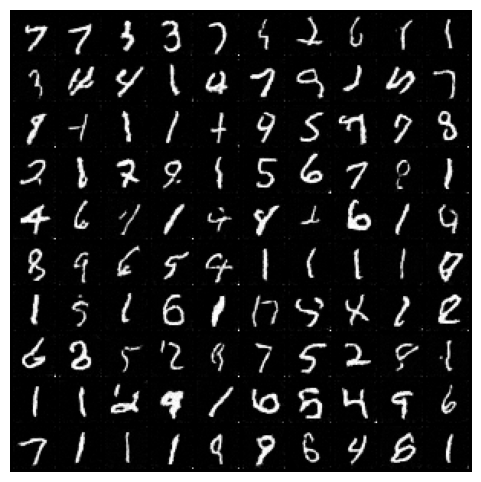

In [8]:
plot_generation(
    score_model=score_model,
    sample_shape=sample_shape,
    sampler="em",
    sampler_params={"forward_pdf_std": forward_pdf_std, "diffusion_coeff": diffusion_coeff, "sigma": sigma, "num_steps": num_steps},
    device=device,
    eps=eps,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.51it/s]


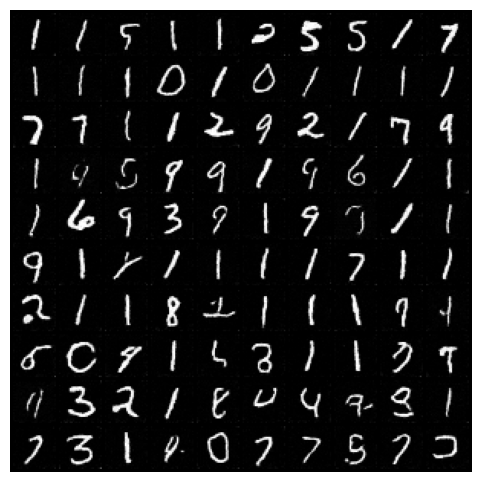

In [9]:
plot_generation(
    score_model=score_model,
    sample_shape=sample_shape,
    sampler="pc",
    sampler_params={"forward_pdf_std": forward_pdf_std, "diffusion_coeff": diffusion_coeff, "sigma": sigma, "num_steps": num_steps, "snr": snr},
    device=device,
    eps=eps,
)

Number of function evaluations: 314


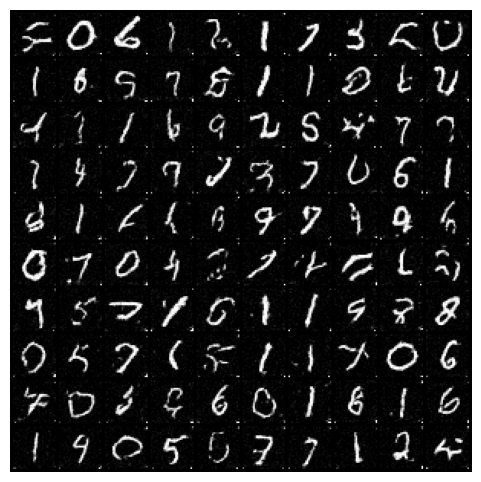

In [10]:
plot_generation(
    score_model=score_model,
    sample_shape=sample_shape,
    sampler="ode",
    sampler_params={"forward_pdf_std": forward_pdf_std, "diffusion_coeff": diffusion_coeff, "sigma": sigma, "atol": atol, "rtol": rtol},
    device=device,
    eps=eps,
)